In [3]:
import pandas as pd
import numpy as numpy
import json 
import os 
import pylab as pl
import urllib
import requests
import geopandas as gp
import fiona
import shapely
from fiona.crs import from_epsg
import os
import pandas as pd
import urllib
import requests
import json
import sys
import io
import shapely
import base64
import urllib.request
import functools
import geopandas as gp
import fiona
import numpy as np
import matplotlib.pylab as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline

In [4]:
url = 'https://data.cityofnewyork.us/api/views/8h9b-rp9u/rows.csv?accessType=DOWNLOAD'
arrests = pd.read_csv(url)
arrests.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
0,173130602,12/31/2017,566.0,"MARIJUANA, POSSESSION",678.0,MISCELLANEOUS PENAL LAW,PL 2210500,V,Q,105,0.0,25-44,M,BLACK,1063056.0,207463.0,40.735772,-73.715638
1,173114463,12/31/2017,478.0,"THEFT OF SERVICES, UNCLASSIFIED",343.0,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,Q,114,0.0,25-44,M,ASIAN / PACIFIC ISLANDER,1009113.0,219613.0,40.769437,-73.910241
2,173113513,12/31/2017,849.0,"NY STATE LAWS,UNCLASSIFIED VIOLATION",677.0,OTHER STATE LAWS,LOC000000V,V,K,73,1.0,18-24,M,BLACK,1010719.0,186857.0,40.679525,-73.904572
3,173113423,12/31/2017,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,18,0.0,25-44,M,WHITE,987831.0,217446.0,40.763523,-73.987074
4,173113421,12/31/2017,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,18,0.0,45-64,M,BLACK,987073.0,216078.0,40.759768,-73.989811


In [5]:
violent = [139,140,153,155,157,164,166,168,175,176
          ,177,178,179,180,183,185,187,261,263,379
           ,380,397,586,639,640,665,104,105,106,
          107,109,112,122,123,124,125,129]
qol = [789,566,258,610, 612, 614, 616, 622, 803, 862]

violations = 789,566,258,604,617,600,602,610, 612, 614, 616, 622, 803, 862,625
firework possession, marijuana possession,possession of graffiti instruments,loitering -use control substance,
loitering-prostitution, loitering-sexual deviation, loitering-gambling in a public place, 
, in public under influence of narcotics, alcohol under 21, public consumption of alc, unreasonable noise

In [6]:
arrests['year'] = arrests['ARREST_DATE'].str[-2:]
arrests.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,year
0,173130602,12/31/2017,566.0,"MARIJUANA, POSSESSION",678.0,MISCELLANEOUS PENAL LAW,PL 2210500,V,Q,105,0.0,25-44,M,BLACK,1063056.0,207463.0,40.735772,-73.715638,17
1,173114463,12/31/2017,478.0,"THEFT OF SERVICES, UNCLASSIFIED",343.0,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,Q,114,0.0,25-44,M,ASIAN / PACIFIC ISLANDER,1009113.0,219613.0,40.769437,-73.910241,17
2,173113513,12/31/2017,849.0,"NY STATE LAWS,UNCLASSIFIED VIOLATION",677.0,OTHER STATE LAWS,LOC000000V,V,K,73,1.0,18-24,M,BLACK,1010719.0,186857.0,40.679525,-73.904572,17
3,173113423,12/31/2017,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,18,0.0,25-44,M,WHITE,987831.0,217446.0,40.763523,-73.987074,17
4,173113421,12/31/2017,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,18,0.0,45-64,M,BLACK,987073.0,216078.0,40.759768,-73.989811,17


In [7]:
arrests = arrests[(arrests['PD_CD'].isin(violent))|(arrests['PD_CD'].isin(qol))]

In [8]:
arrests.shape

(435490, 19)

In [9]:
arrests.loc[arrests['PD_CD'].isin(violent), 'category'] = 'vio'
arrests.loc[arrests['PD_CD'].isin(qol), 'category'] = 'qol'

In [10]:
arrests.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,year,category
0,173130602,12/31/2017,566.0,"MARIJUANA, POSSESSION",678.0,MISCELLANEOUS PENAL LAW,PL 2210500,V,Q,105,0.0,25-44,M,BLACK,1063056.0,207463.0,40.735772,-73.715638,17,qol
5,173130583,12/31/2017,397.0,"ROBBERY,UNCLASSIFIED,OPEN AREAS",105.0,ROBBERY,PL 1601001,F,K,73,0.0,18-24,M,BLACK,1007524.0,188555.0,40.684194,-73.916085,17,vio
12,173126364,12/31/2017,109.0,"ASSAULT 2,1,UNCLASSIFIED",106.0,FELONY ASSAULT,PL 1200501,F,K,60,0.0,<18,F,BLACK,986771.0,148698.0,40.574825,-73.990927,17,vio
17,173117305,12/31/2017,639.0,AGGRAVATED HARASSMENT 2,361.0,OFF. AGNST PUB ORD SENSBLTY & RGHTS TO PRIV,PL 2402500,M,Q,104,0.0,18-24,M,BLACK,1013787.0,195967.0,40.704520,-73.893470,17,vio
24,173128431,12/31/2017,397.0,"ROBBERY,UNCLASSIFIED,OPEN AREAS",105.0,ROBBERY,PL 1600500,F,M,34,0.0,25-44,M,WHITE HISPANIC,1006797.0,253850.0,40.863414,-73.918487,17,vio


In [11]:
grouped = arrests.groupby(['ARREST_PRECINCT','category']).count().reset_index()
grouped.head()

,ARREST_PRECINCT,category,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,year
0,1,qol,625,625,625,625,625,625,625,625,625,625,625,625,625,625,625,625,625,625
1,1,vio,2020,2020,2020,2015,2015,2015,2020,2020,2020,2019,2020,2020,2020,2020,2020,2020,2020,2020
2,5,qol,434,434,434,434,434,434,434,434,434,434,434,434,434,434,434,434,434,434
3,5,vio,5419,5419,5419,5382,5382,5382,5419,5419,5419,5419,5419,5419,5419,5419,5419,5419,5419,5419
4,6,qol,321,321,321,321,321,321,321,321,321,321,321,321,321,321,321,321,321,321


In [12]:
grouped = grouped[['ARREST_PRECINCT','category','ARREST_KEY']]

In [13]:
grouped = grouped.pivot(index='ARREST_PRECINCT', columns='category', values='ARREST_KEY')
grouped.head()

category,qol,vio
ARREST_PRECINCT,,
1,625,2020
5,434,5419
6,321,3684
7,624,3154
9,479,3400


In [36]:
grouped['qol_vio_ratio'] = grouped['qol']/grouped['vio']

grouped.describe()

category,qol,vio,qol_vio_ratio
count,77.000000,77.000000,77.000000
mean,361.415584,5294.298701,0.081890
std,195.219199,2985.808918,0.051530
min,22.000000,343.000000,0.015374
25%,226.000000,3153.000000,0.050788
50%,318.000000,4588.000000,0.068749
75%,470.000000,6692.000000,0.095248
max,1207.000000,15476.000000,0.309406


In [37]:
#import precinct shapefile

url = 'https://data.cityofnewyork.us/api/geospatial/78dh-3ptz?method=export&format=Shapefile'
precinct = gp.GeoDataFrame.from_file(url)
precinct.head(2)

,precinct,shape_area,shape_leng,geometry
0,1.0,4.730176e+07,80586.154615,(POLYGON ((-74.0438776157395 40.69018767637665...
1,5.0,1.808880e+07,18676.124259,POLYGON ((-73.98863862848766 40.72293372026369...


In [38]:
#join to model data

precinct = precinct.merge(grouped,left_on='precinct', right_on='ARREST_PRECINCT')

precinct.shape

(77, 7)

In [39]:
path = '/Users/katharinevoorhees/patrol_allocation/precinct_population_dayadjust.csv'

pop = pd.read_csv(path)

pop.head()

,Unnamed: 0,precinct,resident_pop_x,county,day_allocation,adjusted_day_precinct
0,0,1.0,66751,61.0,271932.341967,338683.341967
1,1,5.0,57779,61.0,59919.357234,117698.357234
2,2,6.0,61230,61.0,40623.963767,101853.963767
3,3,7.0,51539,61.0,14779.598969,66318.598969
4,4,9.0,77426,61.0,26164.362216,103590.362216


In [40]:
precinct = precinct.merge(pop, on='precinct')

In [41]:
precinct.head()

,precinct,shape_area,shape_leng,geometry,qol,vio,qol_vio_ratio,Unnamed: 0,resident_pop_x,county,day_allocation,adjusted_day_precinct
0,1.0,4.730176e+07,80586.154615,(POLYGON ((-74.0438776157395 40.69018767637665...,625,2020,0.309406,0,66751,61.0,271932.341967,338683.341967
1,5.0,1.808880e+07,18676.124259,POLYGON ((-73.98863862848766 40.72293372026369...,434,5419,0.080089,1,57779,61.0,59919.357234,117698.357234
2,6.0,2.209819e+07,26402.900669,POLYGON ((-73.99968392160721 40.73855224865976...,321,3684,0.087134,2,61230,61.0,40623.963767,101853.963767
3,71.0,4.533179e+07,29978.094261,POLYGON ((-73.92854313809303 40.66457328584737...,317,6692,0.047370,58,101871,47.0,7121.926986,108992.926986
4,72.0,1.046213e+08,87968.194520,POLYGON ((-73.99840899113158 40.67186872303234...,330,4780,0.069038,59,144015,47.0,25562.737348,169577.737348


In [42]:
precinct['percapita_day'] = (precinct['qol']/\
        precinct['adjusted_day_precinct'])*10000

In [43]:
precinct = precinct[precinct.precinct != 22]

In [44]:
precinct.to_crs(epsg=2263, inplace=True)

/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


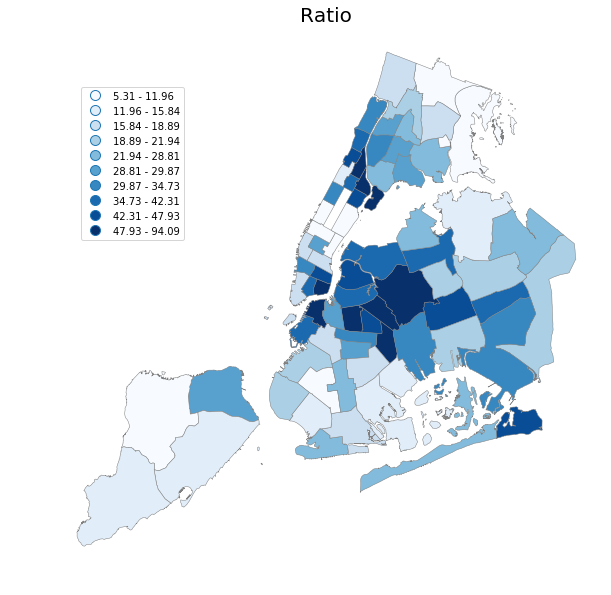

In [45]:
 #make cloropleth of precincts shaded by allocation in this model 

f,ax = plt.subplots(figsize=(10,10))
precinct.plot(column='percapita_day', cmap="Blues", edgecolor="grey",ax=ax,
              scheme='quantiles',k=10, lw=.5, legend=True)
ax.axis('off')
plt.title('Ratio' ,fontsize=(20))

leg = ax.get_legend()
leg.set_bbox_to_anchor((0,-.1,.25,1));

In [46]:
precinct.sort_values('qol_vio_ratio', ascending=False)

,precinct,shape_area,shape_leng,geometry,qol,vio,qol_vio_ratio,Unnamed: 0,resident_pop_x,county,day_allocation,adjusted_day_precinct,percapita_day
0,1.0,4.730176e+07,80586.154615,(POLYGON ((972081.7882080087 190733.4674071776...,625,2020,0.309406,0,66751,61.0,271932.341967,338683.341967,18.453816
61,104.0,2.105047e+08,75785.945508,"POLYGON ((1015372.059631349 206818.6647948657,...",1207,4333,0.278560,38,168770,81.0,23163.749579,191933.749579,62.886283
5,7.0,1.836402e+07,17301.308682,"POLYGON ((991608.6323852561 201215.2305907686,...",624,3154,0.197844,3,51539,61.0,14779.598969,66318.598969,94.091252
65,108.0,1.395924e+08,73058.718660,(POLYGON ((995069.2977905289 212441.0303954545...,592,3153,0.187758,42,110476,81.0,37003.471361,147479.471361,40.141180
56,94.0,6.564186e+07,44570.169837,"POLYGON ((1005129.60662842 201559.2760009205, ...",318,1828,0.173961,71,59485,47.0,12705.169255,72190.169255,44.050319
68,111.0,2.601573e+08,97448.260334,"POLYGON ((1063614.448242189 216235.8699950637,...",286,1771,0.161491,45,120195,81.0,9379.055004,129574.055004,22.072320
75,123.0,4.608700e+08,120830.181066,"POLYGON ((937062.2548217741 143738.0678100044,...",155,1036,0.149614,75,98241,85.0,3837.487936,102078.487936,15.184394
6,9.0,2.139423e+07,19773.233410,"POLYGON ((992119.1235961911 204042.760986278, ...",479,3400,0.140882,4,77426,61.0,26164.362216,103590.362216,46.239823
10,14.0,2.051016e+07,20974.709243,"POLYGON ((991274.0015869105 213749.6546019926,...",821,5852,0.140294,7,15038,61.0,269737.285077,284775.285077,28.829749
48,76.0,4.823865e+07,68146.387666,"POLYGON ((983766.4722290046 191538.8981933044,...",226,1812,0.124724,62,48042,47.0,8425.675295,56467.675295,40.022898


In [47]:
path = '/Users/katharinevoorhees/Downloads/stopfrisk_noarrest_rate.csv'
stopfrisk = pd.read_csv(path)

In [48]:
stopfrisk.head()

,Unnamed: 0,precinct,2018_no_rate,2017_no_rate,2016_no_rate,2015_no_rate,2014_no_rate,2013_no_rate,2012_no_rate,2011_no_rate,2010_no_rate
0,0,1.0,0.737374,0.872340,0.867925,0.911111,0.875000,0.919758,0.938094,0.940706,0.893704
1,1,5.0,0.747126,0.527778,0.787500,0.855615,0.781818,0.890681,0.890726,0.880693,0.881574
2,2,6.0,0.407767,0.698113,0.709677,0.888889,0.887850,0.919089,0.945010,0.924848,0.924993
3,3,7.0,0.731884,0.527273,0.773585,0.824242,0.735736,0.815179,0.890888,0.881733,0.870347
4,4,9.0,0.677966,0.552486,0.787500,0.639847,0.510101,0.753348,0.809163,0.833240,0.855515


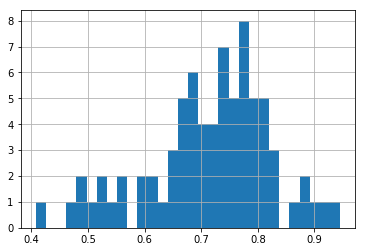

In [49]:
stopfrisk['2018_no_rate'].hist(bins=30)

In [51]:
precinct.shape

(75, 13)

In [52]:
precinct2 = precinct.merge(stopfrisk, on='precinct') 
precinct2.shape

(74, 23)

In [56]:
precinct2.head()

,precinct,shape_area,shape_leng,geometry,qol,vio,qol_vio_ratio,Unnamed: 0_x,resident_pop_x,county,day_allocation,adjusted_day_precinct,percapita_day,Unnamed: 0_y,2018_no_rate,2017_no_rate,2016_no_rate,2015_no_rate,2014_no_rate,2013_no_rate,2012_no_rate,2011_no_rate,2010_no_rate
0,1.0,4.730176e+07,80586.154615,(POLYGON ((972081.7882080087 190733.4674071776...,625,2020,0.309406,0,66751,61.0,271932.341967,338683.341967,18.453816,0,0.737374,0.872340,0.867925,0.911111,0.875000,0.919758,0.938094,0.940706,0.893704
1,5.0,1.808880e+07,18676.124259,"POLYGON ((987399.20678711 202660.9920043435, 9...",434,5419,0.080089,1,57779,61.0,59919.357234,117698.357234,36.873922,1,0.747126,0.527778,0.787500,0.855615,0.781818,0.890681,0.890726,0.880693,0.881574
2,6.0,2.209819e+07,26402.900669,"POLYGON ((984337.591796876 208351.1055907656, ...",321,3684,0.087134,2,61230,61.0,40623.963767,101853.963767,31.515710,2,0.407767,0.698113,0.709677,0.888889,0.887850,0.919089,0.945010,0.924848,0.924993
3,71.0,4.533179e+07,29978.094261,"POLYGON ((1004074.144409176 181406.4476317937,...",317,6692,0.047370,58,101871,47.0,7121.926986,108992.926986,29.084456,43,0.877095,0.845000,0.868687,0.873016,0.906593,0.911538,0.924294,0.912371,0.962840
4,72.0,1.046213e+08,87968.194520,"POLYGON ((984691.3424072284 184056.300231885, ...",330,4780,0.069038,59,144015,47.0,25562.737348,169577.737348,19.460102,44,0.787565,0.600000,0.578947,0.865772,0.933333,0.930243,0.955761,0.968181,0.923235


/Users/katharinevoorhees/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


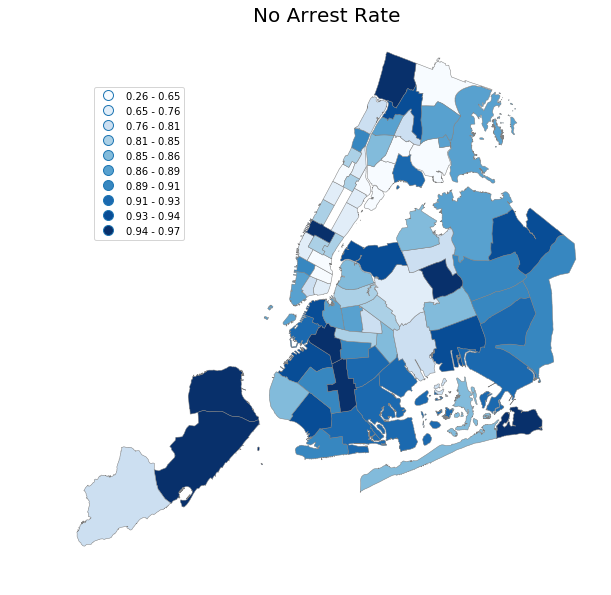

In [61]:
#make cloropleth of precincts shaded by allocation in this model 

f,ax = plt.subplots(figsize=(10,10))
precinct2.plot(column='2014_no_rate', cmap="Blues", edgecolor="grey",ax=ax,
              scheme='quantiles',k=10, lw=.5, legend=True)
ax.axis('off')
plt.title('No Arrest Rate' ,fontsize=(20))

leg = ax.get_legend()
leg.set_bbox_to_anchor((0,-.1,.25,1));

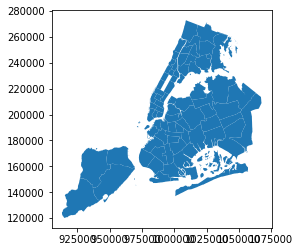

In [59]:
precinct.plot()

In [60]:
precinct2.head()

,precinct,shape_area,shape_leng,geometry,qol,vio,qol_vio_ratio,Unnamed: 0_x,resident_pop_x,county,day_allocation,adjusted_day_precinct,percapita_day,Unnamed: 0_y,2018_no_rate,2017_no_rate,2016_no_rate,2015_no_rate,2014_no_rate,2013_no_rate,2012_no_rate,2011_no_rate,2010_no_rate
0,1.0,4.730176e+07,80586.154615,(POLYGON ((972081.7882080087 190733.4674071776...,625,2020,0.309406,0,66751,61.0,271932.341967,338683.341967,18.453816,0,0.737374,0.872340,0.867925,0.911111,0.875000,0.919758,0.938094,0.940706,0.893704
1,5.0,1.808880e+07,18676.124259,"POLYGON ((987399.20678711 202660.9920043435, 9...",434,5419,0.080089,1,57779,61.0,59919.357234,117698.357234,36.873922,1,0.747126,0.527778,0.787500,0.855615,0.781818,0.890681,0.890726,0.880693,0.881574
2,6.0,2.209819e+07,26402.900669,"POLYGON ((984337.591796876 208351.1055907656, ...",321,3684,0.087134,2,61230,61.0,40623.963767,101853.963767,31.515710,2,0.407767,0.698113,0.709677,0.888889,0.887850,0.919089,0.945010,0.924848,0.924993
3,71.0,4.533179e+07,29978.094261,"POLYGON ((1004074.144409176 181406.4476317937,...",317,6692,0.047370,58,101871,47.0,7121.926986,108992.926986,29.084456,43,0.877095,0.845000,0.868687,0.873016,0.906593,0.911538,0.924294,0.912371,0.962840
4,72.0,1.046213e+08,87968.194520,"POLYGON ((984691.3424072284 184056.300231885, ...",330,4780,0.069038,59,144015,47.0,25562.737348,169577.737348,19.460102,44,0.787565,0.600000,0.578947,0.865772,0.933333,0.930243,0.955761,0.968181,0.923235


In [66]:
precinct2['no_arrest_quantile_2011'] = pd.qcut(precinct2['2011_no_rate'], 10, labels=False)
precinct2['no_arrest_quantile_2014'] = pd.qcut(precinct2['2014_no_rate'], 10, labels=False)
precinct2['no_arrest_quantile_2018'] = pd.qcut(precinct2['2018_no_rate'], 10, labels=False)

precinct2.head()

,precinct,shape_area,shape_leng,geometry,qol,vio,qol_vio_ratio,Unnamed: 0_x,resident_pop_x,county,day_allocation,adjusted_day_precinct,percapita_day,Unnamed: 0_y,2018_no_rate,2017_no_rate,2016_no_rate,2015_no_rate,2014_no_rate,2013_no_rate,2012_no_rate,2011_no_rate,2010_no_rate,quantile_2011,quantile_2014,quantile_2018,no_arrest_quantile_2011,no_arrest_quantile_2014,no_arrest_quantile_2018
0,1.0,4.730176e+07,80586.154615,(POLYGON ((972081.7882080087 190733.4674071776...,625,2020,0.309406,0,66751,61.0,271932.341967,338683.341967,18.453816,0,0.737374,0.872340,0.867925,0.911111,0.875000,0.919758,0.938094,0.940706,0.893704,5,5,5,5,5,5
1,5.0,1.808880e+07,18676.124259,"POLYGON ((987399.20678711 202660.9920043435, 9...",434,5419,0.080089,1,57779,61.0,59919.357234,117698.357234,36.873922,1,0.747126,0.527778,0.787500,0.855615,0.781818,0.890681,0.890726,0.880693,0.881574,0,2,5,0,2,5
2,6.0,2.209819e+07,26402.900669,"POLYGON ((984337.591796876 208351.1055907656, ...",321,3684,0.087134,2,61230,61.0,40623.963767,101853.963767,31.515710,2,0.407767,0.698113,0.709677,0.888889,0.887850,0.919089,0.945010,0.924848,0.924993,3,6,0,3,6,0
3,71.0,4.533179e+07,29978.094261,"POLYGON ((1004074.144409176 181406.4476317937,...",317,6692,0.047370,58,101871,47.0,7121.926986,108992.926986,29.084456,43,0.877095,0.845000,0.868687,0.873016,0.906593,0.911538,0.924294,0.912371,0.962840,1,6,9,1,6,9
4,72.0,1.046213e+08,87968.194520,"POLYGON ((984691.3424072284 184056.300231885, ...",330,4780,0.069038,59,144015,47.0,25562.737348,169577.737348,19.460102,44,0.787565,0.600000,0.578947,0.865772,0.933333,0.930243,0.955761,0.968181,0.923235,9,8,7,9,8,7


In [67]:
precinct2.columns

Index(['precinct', 'shape_area', 'shape_leng', 'geometry', 'qol', 'vio',
       'qol_vio_ratio', 'Unnamed: 0_x', 'resident_pop_x', 'county',
       'day_allocation', 'adjusted_day_precinct', 'percapita_day',
       'Unnamed: 0_y', '2018_no_rate', '2017_no_rate', '2016_no_rate',
       '2015_no_rate', '2014_no_rate', '2013_no_rate', '2012_no_rate',
       '2011_no_rate', '2010_no_rate', 'quantile_2011', 'quantile_2014',
       'quantile_2018', 'no_arrest_quantile_2011', 'no_arrest_quantile_2014',
       'no_arrest_quantile_2018'],
      dtype='object')

In [71]:
export = precinct2[['precinct', 'qol', 'vio','adjusted_day_precinct',
                 'percapita_day', '2018_no_rate', '2014_no_rate', '2011_no_rate', 'no_arrest_quantile_2011', 
                    'no_arrest_quantile_2014','no_arrest_quantile_2018']]

In [72]:
export.head()

,precinct,qol,vio,adjusted_day_precinct,percapita_day,2018_no_rate,2014_no_rate,2011_no_rate,no_arrest_quantile_2011,no_arrest_quantile_2014,no_arrest_quantile_2018
0,1.0,625,2020,338683.341967,18.453816,0.737374,0.875000,0.940706,5,5,5
1,5.0,434,5419,117698.357234,36.873922,0.747126,0.781818,0.880693,0,2,5
2,6.0,321,3684,101853.963767,31.515710,0.407767,0.887850,0.924848,3,6,0
3,71.0,317,6692,108992.926986,29.084456,0.877095,0.906593,0.912371,1,6,9
4,72.0,330,4780,169577.737348,19.460102,0.787565,0.933333,0.968181,9,8,7


In [73]:
export.to_csv('no_arrest_rates_and_qol_pc.csv')

In [33]:
#look specifically at stop and frisks for suspicion of un-super-scary crimes